In [126]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import statsmodels.formula.api as smf
import statsmodels.api as sm
from datetime import datetime, timedelta
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.api import VAR
from statsmodels.tsa.base.datetools import dates_from_str
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from sktime.transformations.series.boxcox import LogTransformer
from sktime.utils.plotting import plot_correlations
from sktime.utils.plotting import plot_series
from sktime.transformations.series.difference import Differencer

In [127]:
dataBMW = yf.download("BMW.DE", start="2008-12-31", end="2020-10-31")[['Adj Close']]
dataVW = yf.download("VOW.DE", start="2008-12-31", end="2020-10-31")[['Adj Close']]

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [128]:
dataBMW = dataBMW.resample("m").last()
dataVW = dataVW.resample("m").last()

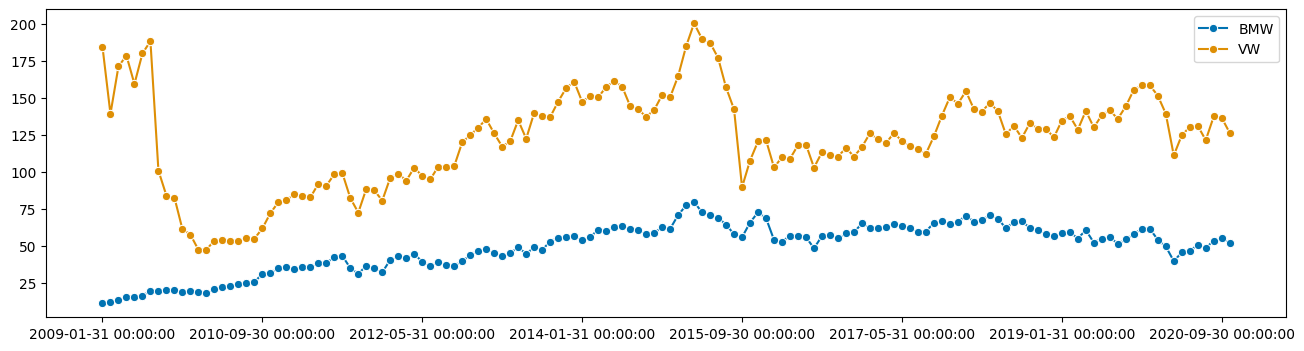

In [129]:
fig, ax = plot_series(dataBMW, dataVW, 
            labels=["BMW", "VW"]);

In [130]:
leadBMW = pd.DataFrame()
leadBMW["BMW"] = dataBMW
leadBMW["VW"] = dataVW

leadVW = leadBMW[leadBMW.columns[::-1]]

In [131]:
d_leadBMW=leadBMW.diff().dropna()

<AxesSubplot: >

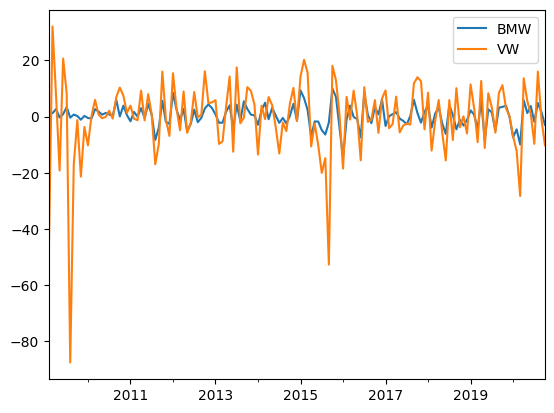

In [132]:
d_leadBMW.plot(legend=True,label='TRAIN')

In [133]:
gc_res = grangercausalitytests(d_leadBMW, 30)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.6458  , p=0.2017  , df_denom=137, df_num=1
ssr based chi2 test:   chi2=1.6818  , p=0.1947  , df=1
likelihood ratio test: chi2=1.6718  , p=0.1960  , df=1
parameter F test:         F=1.6458  , p=0.2017  , df_denom=137, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.1497  , p=0.3198  , df_denom=134, df_num=2
ssr based chi2 test:   chi2=2.3852  , p=0.3034  , df=2
likelihood ratio test: chi2=2.3650  , p=0.3065  , df=2
parameter F test:         F=1.1497  , p=0.3198  , df_denom=134, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.9560  , p=0.4157  , df_denom=131, df_num=3
ssr based chi2 test:   chi2=3.0212  , p=0.3884  , df=3
likelihood ratio test: chi2=2.9886  , p=0.3934  , df=3
parameter F test:         F=0.9560  , p=0.4157  , df_denom=131, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.8388  , p=0.5030  

In [134]:
model = VAR(d_leadBMW)
model.select_order(30);

In [135]:
results = model.fit(maxlags=30, ic='aic')
results.k_ar

2

In [136]:
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 27, Oct, 2022
Time:                     12:47:55
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    7.69313
Nobs:                     139.000    HQIC:                   7.56781
Log likelihood:          -904.465    FPE:                    1775.93
AIC:                      7.48202    Det(Omega_mle):         1654.74
--------------------------------------------------------------------
Results for equation BMW
            coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------
const          0.287416         0.330788            0.869           0.385
L1.BMW         0.069048         0.102597            0.673           0.501
L1.VW         -0.035054         0.030303           -1.157           0.247
L2.BMW        -0

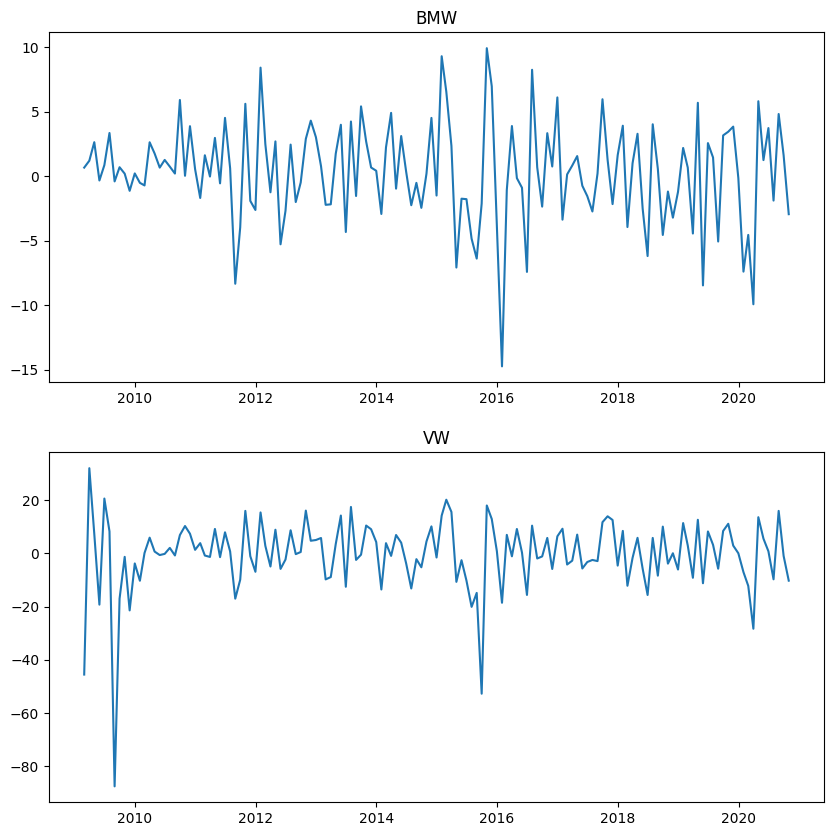

In [137]:
results.plot();

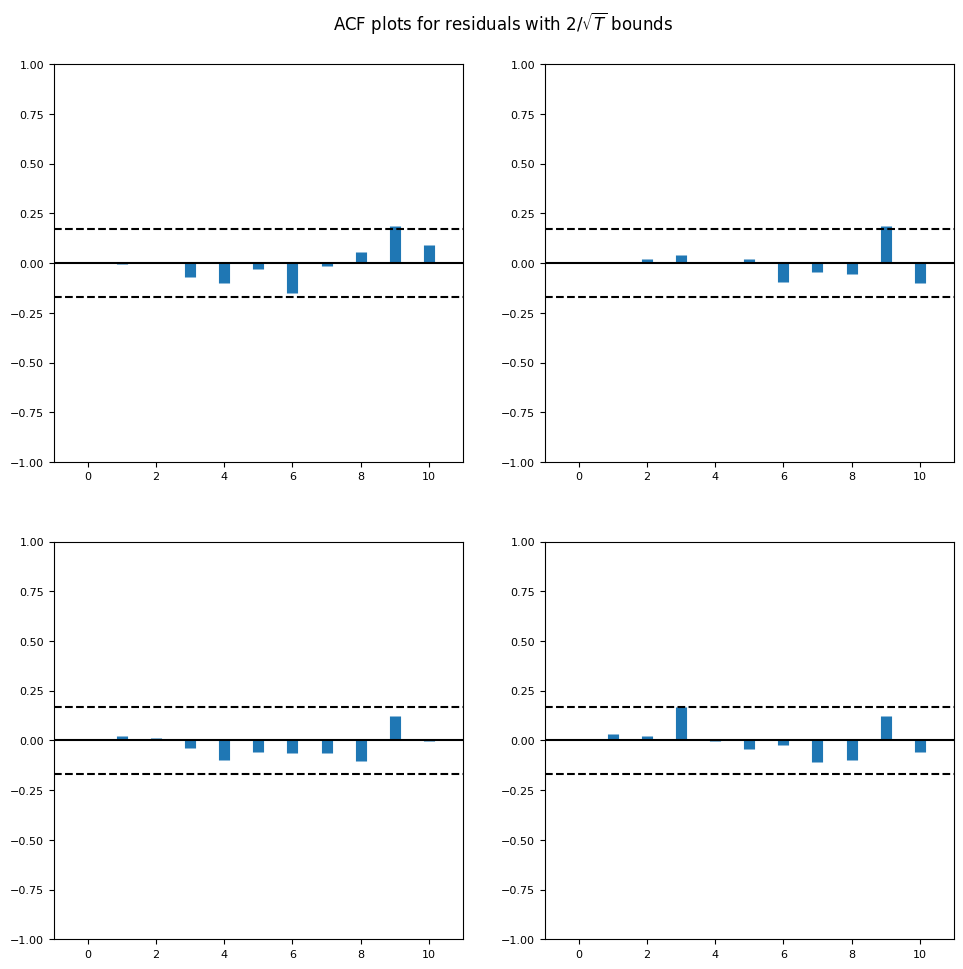

In [138]:
results.plot_acorr();

In [139]:
results.forecast(d_leadBMW.values[-results.k_ar:], 10)

array([[ 0.26600204, -0.4275491 ],
       [ 0.97649111,  0.27558514],
       [ 0.32436163, -0.21418701],
       [ 0.18828489, -0.24954934],
       [ 0.27501982, -0.35520982],
       [ 0.30260738, -0.36760333],
       [ 0.29719601, -0.32849794],
       [ 0.29238143, -0.32139292],
       [ 0.29135644, -0.32881837],
       [ 0.29194084, -0.3310526 ]])

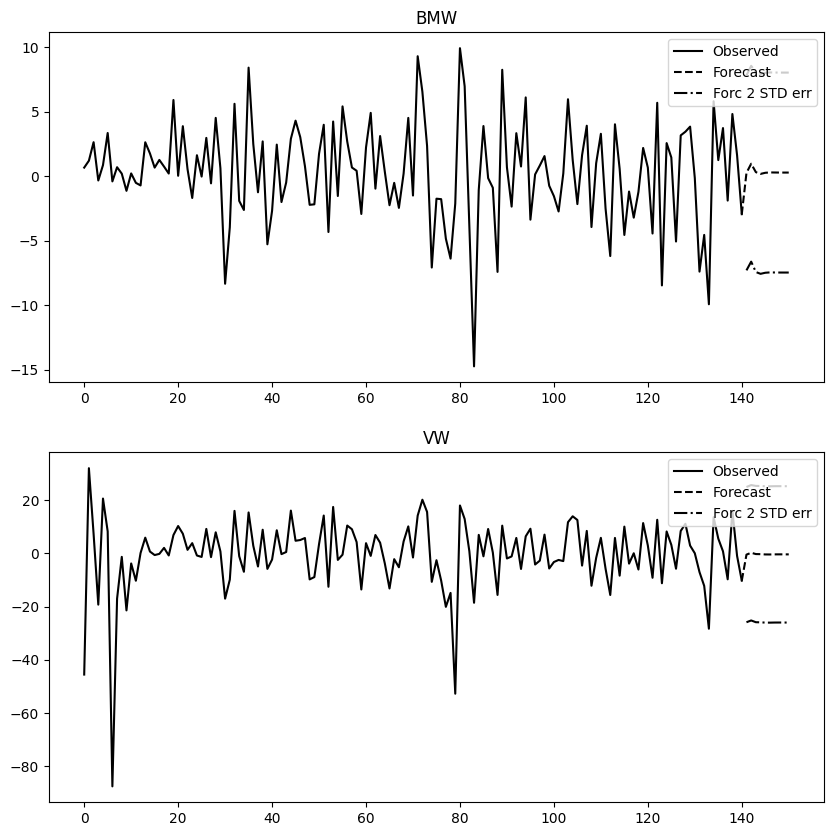

In [140]:
results.plot_forecast(10);

In [141]:
f_data=leadBMW.values[-1:]+results.forecast(d_leadBMW.values[-results.k_ar:], 10)
f_data

array([[ 52.34426055, 125.89887455],
       [ 53.05474962, 126.60200878],
       [ 52.40262014, 126.11223663],
       [ 52.2665434 , 126.0768743 ],
       [ 52.35327833, 125.97121382],
       [ 52.3808659 , 125.95882032],
       [ 52.37545452, 125.9979257 ],
       [ 52.37063995, 126.00503072],
       [ 52.36961496, 125.99760528],
       [ 52.37019936, 125.99537105]])

In [142]:
data_fore=pd.DataFrame(f_data)
data_fore.index=data_test.index
data_fore.rename(columns={0: 'f_BMW', 1: 'f_VW'}, inplace=True)
data_fore

NameError: name 'data_test' is not defined

## ¿Es la Volatilidad de BMW constante? Estimar el modelo garch de BMW (Muestra: Toda la disponible en Yahoo hasta el 31/10/2020)

In [143]:
dataBMW = yf.download("BMW.DE", end="2020-10-31")[['Adj Close']].rename(columns={'Adj Close': 'Price'})


[*********************100%***********************]  1 of 1 completed


In [144]:
dataBMW['log_ret'] =np.log(dataBMW.Price).diff()
dataBMW['Squared'] =dataBMW['log_ret']**2
dataBMW.tail()

,Price,log_ret,Squared
Date,,,
2020-10-26,56.098618,-0.011326,0.000128
2020-10-27,54.554375,-0.027913,0.000779
2020-10-28,51.528015,-0.057072,0.003257
2020-10-29,51.767639,0.004640,0.000022
2020-10-30,52.078259,0.005982,0.000036


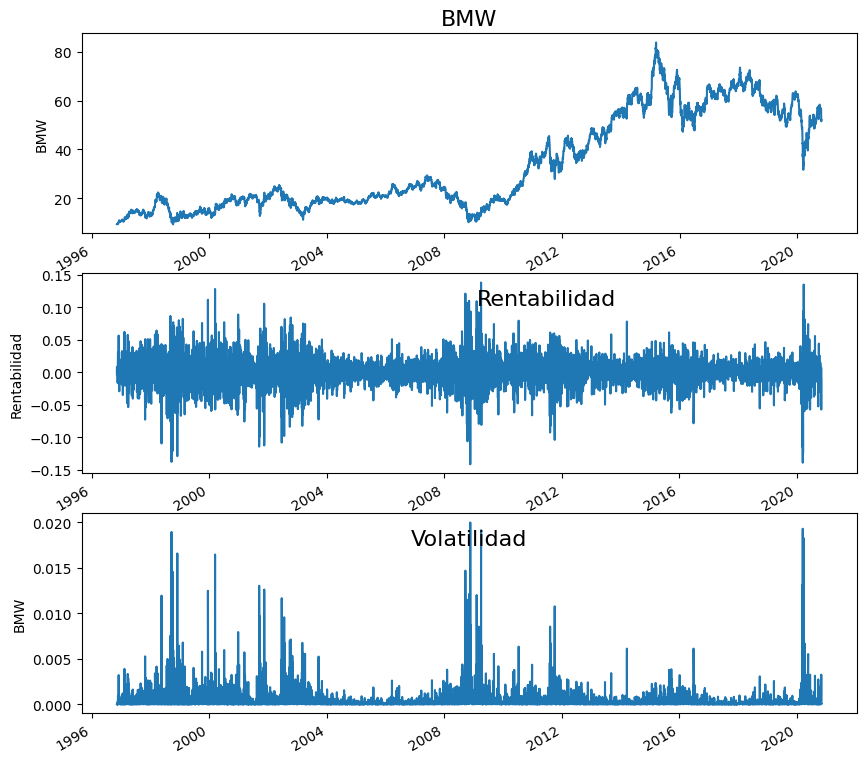

In [145]:
fig = plt.figure(figsize=(10,10))
plt.subplot(311)
ax=dataBMW.Price.plot( linestyle='-')
ax.set_ylabel('BMW')
ax.set_xlabel('')
ax.set_title('BMW', y=1, fontsize = 16)
plt.subplot(312)
ax=dataBMW.log_ret.plot( linestyle='-')
ax.set_ylabel('Rentabilidad')
ax.set_xlabel('')
ax.set_title('Rentabilidad', y=0.8, x=0.6,fontsize = 16)
plt.subplot(313)
ax=dataBMW.Squared.plot( linestyle='-')
ax.set_ylabel('BMW')
ax.set_xlabel('')
ax.set_title('Volatilidad', y=0.8, fontsize = 16);

In [146]:
# mean zero test
from scipy import stats
alpha=0.05
t, p = stats.ttest_1samp(dataBMW['log_ret'].dropna(),0.0)
print ('Estadítico t:', round(t,3))
print ('p-value:', round(p,3))

if  p < alpha:
    print (f'Con {alpha} de significación: Rechazamos la hipotesis de media cero.')
else:
    print (f'Con {alpha} de significación: No podemos rechazar la hipotesis de media cero.')

Estadítico t: 1.006
p-value: 0.314
Con 0.05 de significación: No podemos rechazar la hipotesis de media cero.


In [147]:
BMW_vol=dataBMW['Squared'].astype('float64').to_period('D').sort_index().dropna()
BMW_vol.tail()

Date
2020-10-26    0.000128
2020-10-27    0.000779
2020-10-28    0.003257
2020-10-29    0.000022
2020-10-30    0.000036
Freq: D, Name: Squared, dtype: float64

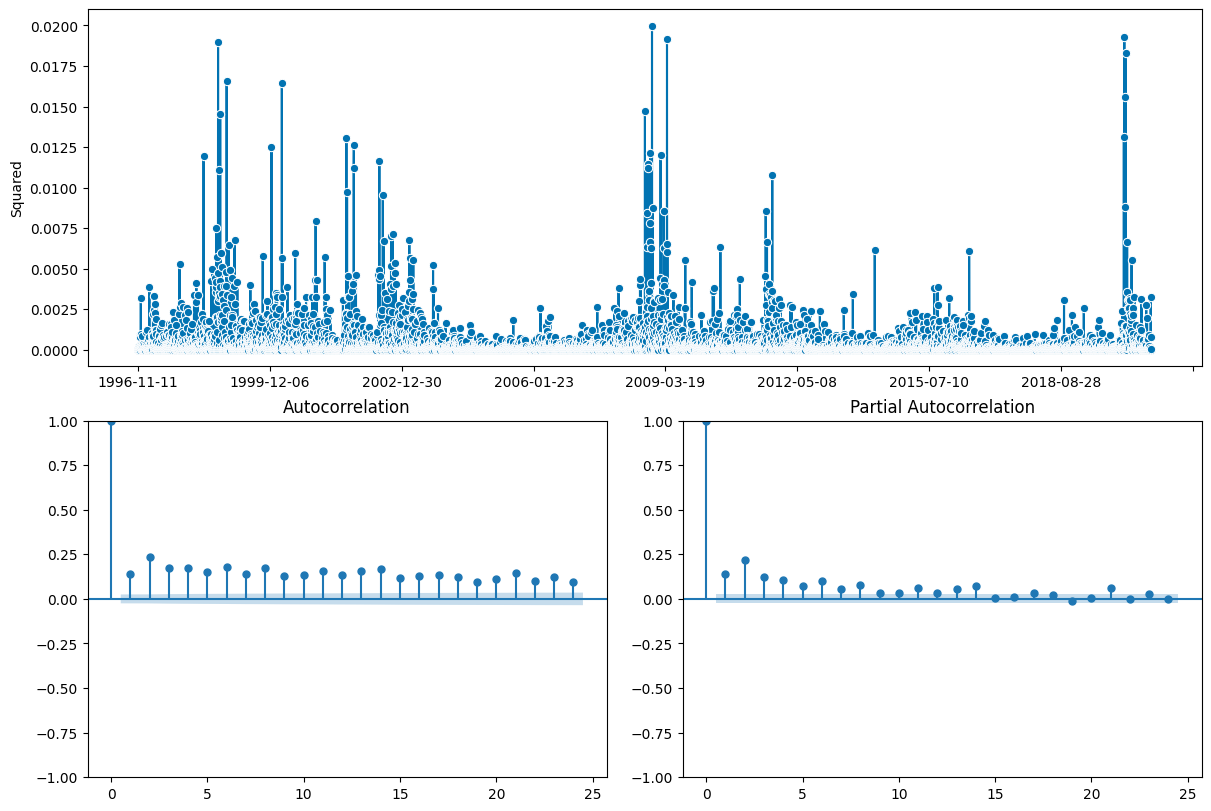

In [148]:
plot_correlations(BMW_vol);

In [150]:
import statsmodels.api as sm
test_Ljung_Box=sm.stats.acorr_ljungbox
test_Ljung_Box(BMW_vol, lags=[1,2,3], return_df=True)

,lb_stat,lb_pvalue
1,123.206149,1.256876e-28
2,457.081453,5.572161e-100
3,637.729560,6.663819e-138


In [151]:
from arch.univariate import ARX
from arch.univariate import ARCH, GARCH
from arch.univariate import StudentsT

In [172]:
ar = ARX(100*dataBMW['log_ret'].dropna(), lags=[1])
ar.volatility = GARCH(p=1,q=1)
ar.distribution = StudentsT()
res = ar.fit(update_freq=0, disp="off")
print(res.summary())

                              AR - GARCH Model Results                              
Dep. Variable:                      log_ret   R-squared:                       0.000
Mean Model:                              AR   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:               -12454.7
Distribution:      Standardized Student's t   AIC:                           24921.4
Method:                  Maximum Likelihood   BIC:                           24961.8
                                              No. Observations:                 6148
Date:                      Thu, Oct 27 2022   Df Residuals:                     6146
Time:                              12:54:09   Df Model:                            2
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
C

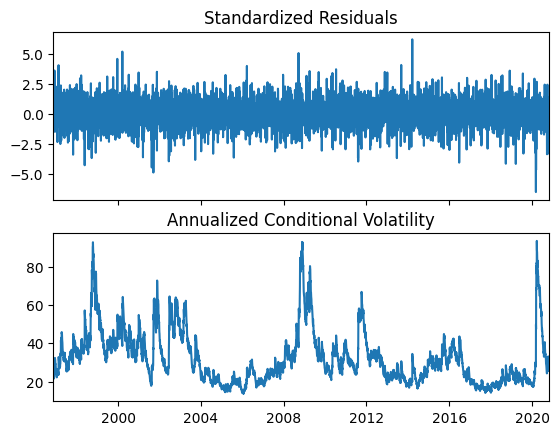

In [173]:
fig = res.plot(annualize="D")

In [174]:
# Análisis Residuos
mod1_std_resid=(res.resid / res.conditional_volatility).astype('float64').to_period('D').sort_index().dropna()

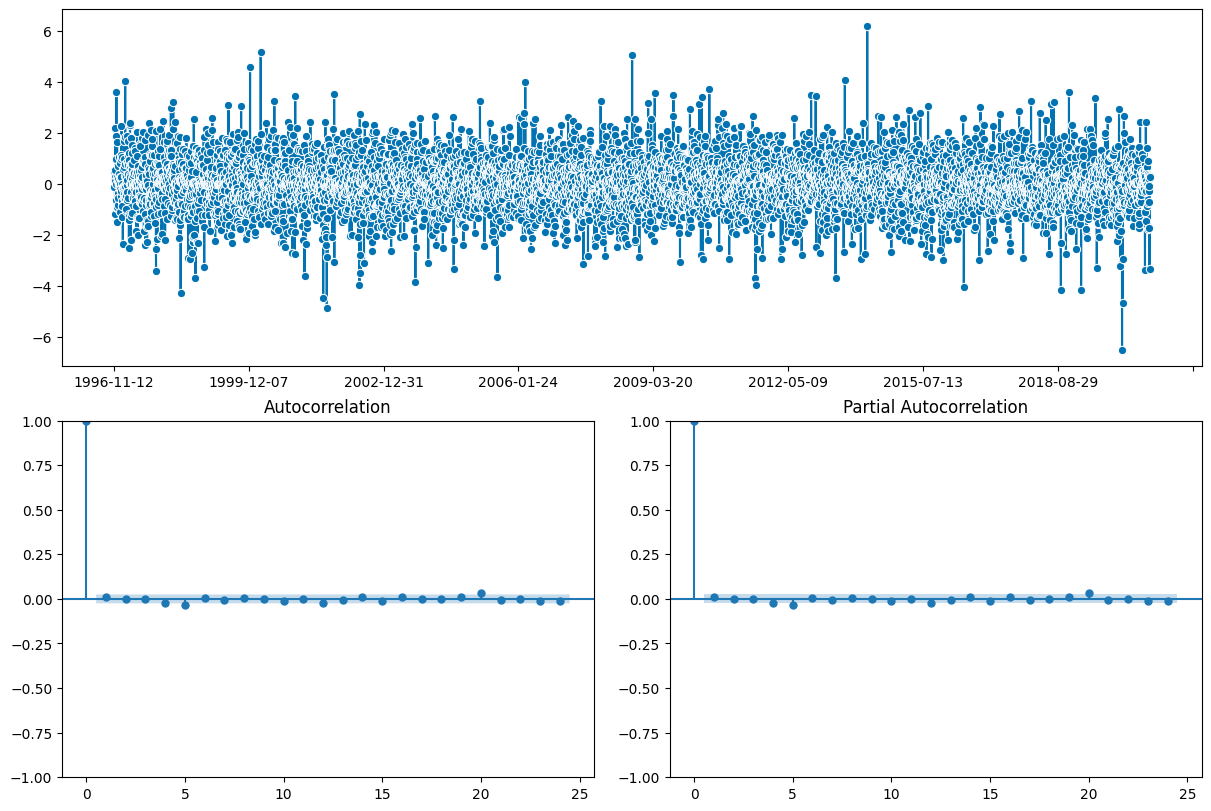

In [175]:
# Plot Autocorrelation
plot_correlations(mod1_std_resid);

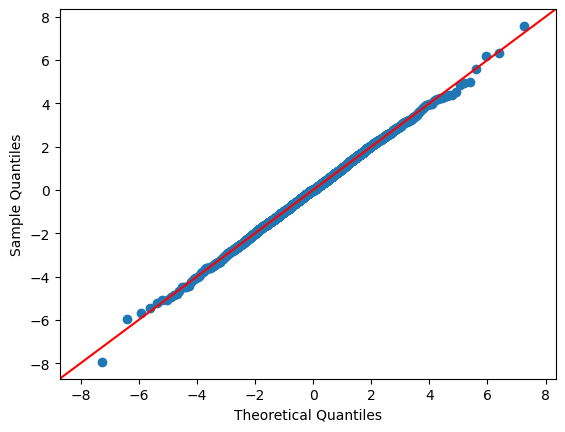

In [176]:
sm.qqplot(mod1_std_resid,dist=stats.t,fit=True,line='45')
plt.show()

In [177]:
forecasts = res.forecast(horizon=30, reindex=False)

In [200]:
# Mean
fordf = pd.DataFrame()
fordf["mean"] = forecasts.mean.transpose()
fordf["variance"] = ((forecasts.variance**0.5)*np.sqrt(252)).transpose()


,mean,variance
h.01,0.058453,31.771674
h.02,0.037142,31.837398
h.03,0.036301,31.878348
h.04,0.036267,31.919137
h.05,0.036266,31.959804
h.06,0.036266,32.000348
h.07,0.036266,32.040772
h.08,0.036266,32.081075
h.09,0.036266,32.121258
h.10,0.036266,32.161322


In [198]:
# Varianza
((forecasts.variance**0.5)*np.sqrt(252)).transpose()

Date,2020-10-30
h.01,31.771674
h.02,31.837398
h.03,31.878348
h.04,31.919137
h.05,31.959804
h.06,32.000348
h.07,32.040772
h.08,32.081075
h.09,32.121258
h.10,32.161322


In [196]:
pred = pd.Series(np.sqrt(forecasts.variance.values[-1,:])*np.sqrt(252))

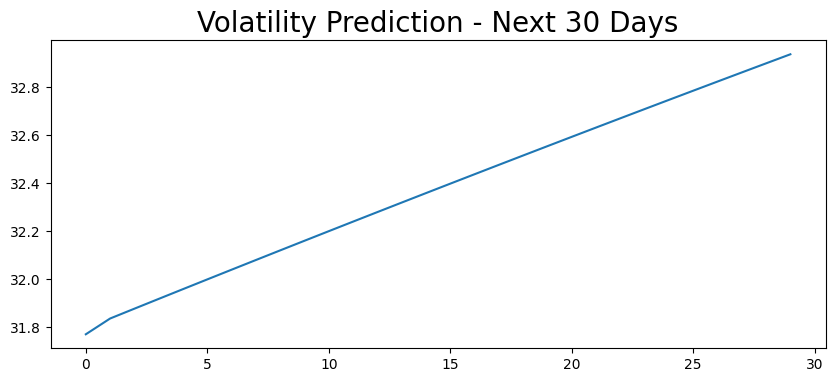

In [182]:
plt.figure(figsize=(10,4))
plt.plot(pred)
plt.title('Volatility Prediction - Next 30 Days', fontsize=20);

In [ ]:
ar = ARX(100*dataBMW['log_ret'].dropna(), lags=[1])
ar.volatility = GARCH(p=1,q=1)
ar.distribution = StudentsT()

In [102]:
returns = 100*dataBMW['log_ret'].dropna()

In [125]:
import warnings
warnings.filterwarnings('ignore')

rolling_predictions = []
test_size = 365*2

for i in range(test_size):
    train = returns[:-(test_size-i)]
    model = ARX(train, lags=[1])
    model.volatility = GARCH(p=1,q=1)
    model.distribution = StudentsT()
    model_fit = model.fit(disp='off')
    pred = model_fit.forecast(horizon=1)
    rolling_predictions.append(np.sqrt(pred.variance.values[-1,:][0]))
    


KeyboardInterrupt: 

In [ ]:
rolling_predictions = pd.Series(rolling_predictions, index=returns.index[-test_size:])
plt.figure(figsize=(10,4))
true, = plt.plot(returns[-365*5:])
preds, = plt.plot(rolling_predictions)
plt.title('Volatility Prediction - Rolling Forecast', fontsize=20)
plt.legend(['True Returns', 'Predicted Volatility'], fontsize=16);

Text(0.5, 1.0, 'Volatility Prediction - November 2020')

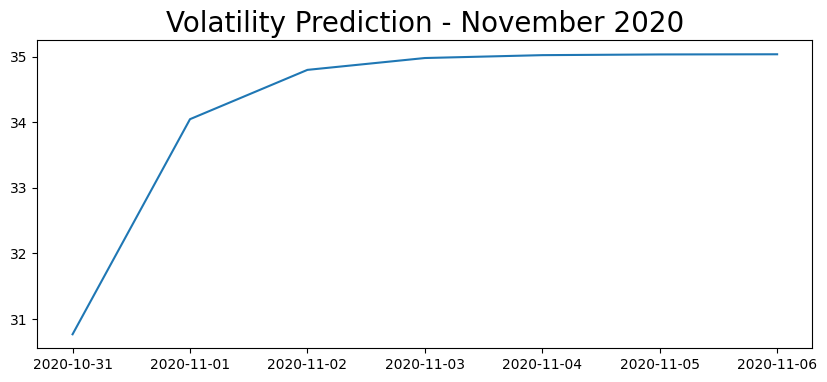

In [124]:
train = returns
model = ARX(train, lags=[1])
model.volatility = ARCH()
model_fit = model.fit(disp='off')
pred = model_fit.forecast(horizon=7)
future_dates = [returns.index[-1] + timedelta(days=i) for i in range(1,8)]
pred = pd.Series(np.sqrt(pred.variance.values[-1,:])*np.sqrt(252), index=future_dates)
plt.figure(figsize=(10,4))
plt.plot(pred)
plt.title('Volatility Prediction - November 2020', fontsize=20)

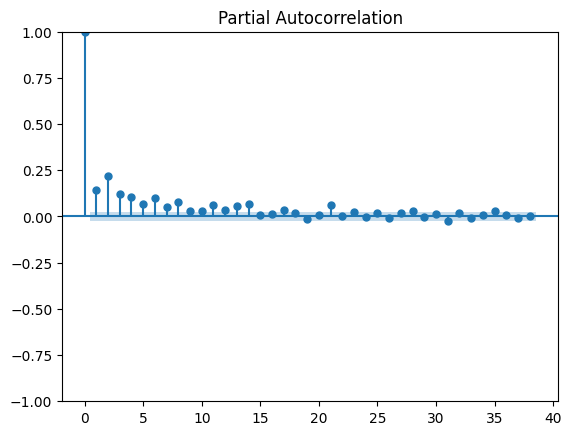

In [115]:
plot_pacf(returns**2)
plt.show()